<a href="https://colab.research.google.com/github/lorransr/tripdetection/blob/master/Rotation%20Matrix%20-%20Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experimento da Matriz de Rotação

No experimento a seguir foi utilizado um celular Xiomi Mi 8 Lite, com o aplicativo "Sensor Record", a fim de se registrar dados de sensores do celular em diferentes posições. 

No caso, foram realizadas 3 viagens em um mesmo percurso:
* Celular Alinhado com o Carro
* Celular Deitado com o botão de volume (eixo x) apontado para frente do carro
* Celular em posição genérica

Nos três casos foi-se utilizado o metodo desenvolvido para se estimar a matriz de rotação. Que consiste em identificar o instante em que o veículo se encontra essencialmente parado, e monitorar a magnitude da aceleração sentida pelo aparelho. No momento em que essa magnitude for 2 vezes maior que a vibração normal do carro - registrada a partir dos primeiros instantes que o celular se encontra parado. Assim sendo, é possivel integrar a aceleração por um periodo curto de tempo, com o objetivo de se estimar a direção do carro. Nesse momento também se toma a média do vetor gravidade atuante sobre o dispositivo. Por fim é possivel se estimar uma matriz de rotação que transforma as coordenadas do celular para as coordenadas do carro.

Para se validar a troca de coordenadas, se observou: 
* A correlação dos dados rotacionados - no caso dos eixos conhecidos;
* A quantidade de energia em Y - uma vez que as corridas se deram no mesmo percurso e em condições muito parecidas, elas tendem a ser próximas
* A direção das curvas, uma vez que o percurso consiste em uma volta em um quarteirão, haverão 4 assinaturas de curva para direita, tanto pelo eixo Z rotacionado do giroscópio, quanto pelo eixo X rotacionado do acelerômetro


In [2]:
!pip install matplotlib==3.0.3

     |████████████████████████████████| 13.0MB 181kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.1.1
    Uninstalling matplotlib-3.1.1:
      Successfully uninstalled matplotlib-3.1.1


In [0]:
import pandas as pd
import numpy as np
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D

In [0]:
root = "https://raw.githubusercontent.com/lorransr/tripdetection/master/Trips/"
folders = ["2019-11-19_14-01-00","2019-11-19_14-03-00","2019-11-19_14-07-00"]
files = ["AccelerometerLinear","GPS","Gyroscope","Gravity"]
# urls = []
# for folder in folders:
#   for file in files:
#     urls.append(root+"/"+folder+"/"+file+".csv")

In [0]:
def sensor_import(folders,csv_name):
  list_1 = []
  #lendo csv's
  id = 0
  for folder in folders:
    path = "{0}/{1}.csv".format(root+folder,csv_name)
    df = pd.read_csv(path, index_col=None, header=0)
    df["ID_viagem"] = id
    df["ts"] = pd.to_datetime(df.Timestamp[0])
    df["ts"] = df["ts"] + pd.to_timedelta(df["Milliseconds"],"ms")
    list_1.append(df)
    frame = pd.concat(list_1,axis=0,ignore_index=False)
    id = id+1
  return frame

In [0]:
def set_ts(raw):
  df = raw.set_index("ts")
  df.drop(["Timestamp","Milliseconds"],axis=1,inplace=True)
  return df

In [0]:
#importing data
raw_acc = sensor_import(folders=folders,csv_name=files[0])
raw_gps = sensor_import(folders=folders,csv_name=files[1])
raw_gyro = sensor_import(folders=folders,csv_name=files[2])
raw_gravity = sensor_import(folders=folders,csv_name=files[3])

#seting ts
acc = set_ts(raw_acc)
gyro = set_ts(raw_gyro)
gps = set_ts(raw_gps)
gravity = set_ts(raw_gravity)

#Remove Duplicated Values
acc = acc.drop_duplicates()
gyro = gyro.drop_duplicates()
gps = gps.drop_duplicates()
gravity = gravity.drop_duplicates()


#change columns
acc.columns = acc.columns.str.lower()+"_acc"
gyro.columns = gyro.columns.str.lower()+"_gyro"
gps.columns = gps.columns.str.lower()+"_gps"
gravity.columns = gravity.columns.str.lower()+"_gravity"

#achango a magnitude do Giroscópio e A
sampling = 50
gyro["G"] = np.linalg.norm(gyro[["x_gyro","y_gyro","z_gyro"]].values,axis=1)
acc["A"] = np.linalg.norm(acc[["x_acc","y_acc","z_acc"]].values,axis=1)

gyro["smoothG"] = gyro.G.rolling(sampling,1).mean()
acc["smoothA"] = acc.A.rolling(sampling,1).mean()

In [0]:
#merging
acc_gyro = acc.join(gyro,how="outer",)
acc_gyro_gravity = acc_gyro.join(gravity,how="outer")
raw = acc_gyro_gravity.join(gps,how="outer")

In [0]:
#sinalizando dados replicados
df = raw.copy()
df["replicated_linear"] = 0
df.loc[df.x_acc.isna(),"replicated_gyro"] = 1
df["replicated_gyro"] = 0
df.loc[df.x_gyro.isna(),"replicated_gyro"] = 1
df["replicated_gravity"] = 0
df.loc[df.x_gravity.isna(),"replicated_gravity"] = 1
df["replicated_gps"] = 0
df.loc[df.latitude_gps.isna(),"replicated_gps"] = 1

In [0]:
#ffill
df = df.ffill()
df.dropna(inplace=True)

In [0]:
trip1 = df[df.id_viagem_acc == 0] #celular alinhado
trip2 = df[df.id_viagem_acc == 1].iloc[10:-10] #celular deitado x apontando pra frente do carro
trip3 = df[df.id_viagem_acc == 2].iloc[10:-10] # celular em posição genêrica

In [0]:
viagem_dict = {}
viagem_dict["trip1"] = trip1
viagem_dict["trip2"] = trip2
viagem_dict["trip3"] = trip3
 

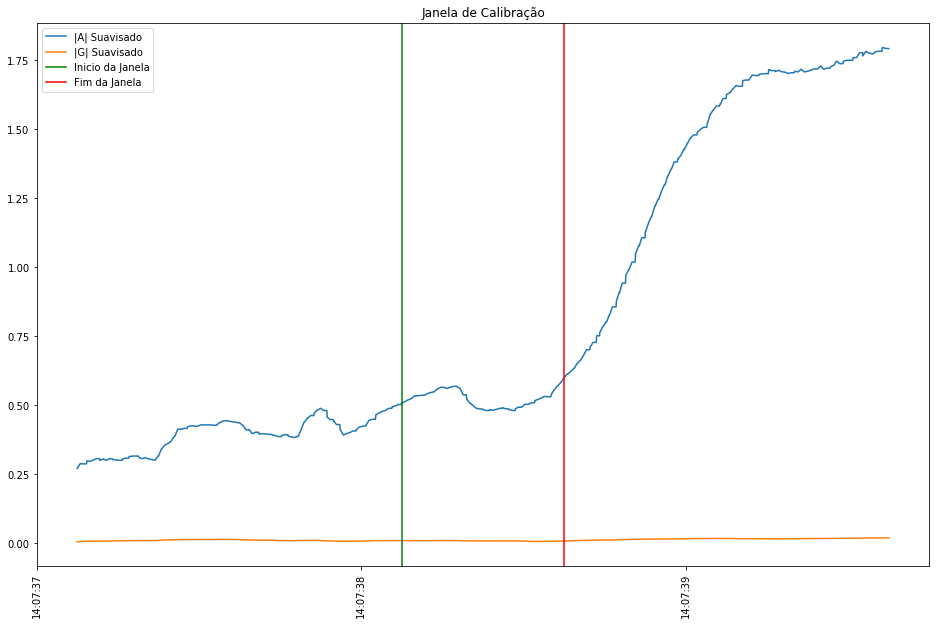

In [59]:
#@title Escolha uma Viagem { run: "auto" }

viagem = "trip3"  #@param ['trip1', 'trip2', 'trip3']

#@markdown Após a escolha será necessário rodar todas as celular abaixo novamente =D

#escolhendo uma viagem
df_merged = viagem_dict[viagem].copy()


energy_level = df_merged.loc[df_merged.smoothG < 0.1].iloc[:100].smoothA.mean()

df_merged["linear_noise_gate_open"] = 0
df_merged.loc[df_merged.smoothA > 2 * energy_level, "linear_noise_gate_open"] = 1

df_merged["gyro_noise_gate_open"] = 0
df_merged.loc[df_merged.smoothG < 0.1, "gyro_noise_gate_open"] = 1

rotation_condition1 = df_merged.gyro_noise_gate_open == 1
rotation_condition2 = df_merged.linear_noise_gate_open == 1
start = df_merged[rotation_condition1 & rotation_condition2].index[0]

milliseconds = 500
deltat = "{}ms".format(milliseconds)
end = start + pd.to_timedelta(deltat)
df_filtered = df_merged[start - pd.to_timedelta("1s"):end + pd.to_timedelta("1s")]

fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(10)
ts = df_filtered.index
ax.plot(ts, df_filtered.smoothA,label="|A| Suavisado")
ax.plot(ts, df_filtered.smoothG,label= "|G| Suavisado")
plt.axvline(start, color="g", label="Inicio da Janela")
plt.axvline(end, color="r", label="Fim da Janela")
plt.xticks(rotation="vertical")
plt.legend()
plt.title("Janela de Calibração")
plt.savefig("janelaCalibracao")


Nosso sistema não pode compreender a dinamica veicular atravez da leitura de sensores, a não ser que o sistema de coordenadas do telefone esteja alinhado com o do veículo. Nossa proposta consiste em alinhar os dois utilizando o gyroscópio e o acelerômetro.

O sistema de coordenadas do telefone ($X_t,Y_t,Z_t$) é determinado pela posição do mesmo, no interior do veículo. Nosso alinhamento do coordenadas consiste em encontrar a matrx de rotação que alinha o sistema de coordenadas do telefone com o do Veículo ($X_v,Y_v,Z_v$). Começamos, definindo um vetor unitário de três coordenadas no sistema de coordenadas do veículo, $\hat{i}$,$\hat{j}$ e $\hat{k}$.(por exemplo com $\hat{i} = [1,0,0]$ no sistema de coordenadas do veículo). Denotamos as coordenadas correspondentes desse vetor unitário no sistema de coordenadas do telefone como:

>$\hat{q} = [x_q,y_q,z_q]^T$

onde $\hat{q} \in i,j,k$  dessa forma a matriz de rotação é dada por:

> $R = \begin{Bmatrix}
x_i &x_j  &x_k \\ 
y_i &y_j  &y_k \\ 
z_i &z_j  &z_k 
\end{Bmatrix}$

----
Para se obter cada elemento da matriz de rotação, utilizamos medições de acelerômetro e do gyroscópio.

- **Derivando $\hat{k}$**: Pode ser obtido utilizando um filtro de pass-baixa(exemplo: suavização exponencial) nos três eixos do acelerômetro para se obter as componentes constantes nesses três eixos, de forma a se econtrar a gravidade, que é então normalizada de forma a gerar o vetor unitário $\hat{k} = [x_k,y_k,z_k]^T$  

- **Derivando $\hat{j}$**:Para se obter $\hat{j}$ lançamos mão do fato de que as leituras nessa direção de movimento do veículo são dadas quando aceleramos ou desaceleramos com o carro em linha reta. Para tal, podemos utilizar o gyroscópio para determinar se o veículo está se locomovendo em linha reta, e em seguida encontramos instantes onde o veículo inicia a aceleração, encontrando $\hat{j} = [x_j,y_j,z_j]^T$. de acordo com esse [artigo](http://www.winlab.rutgers.edu/~gruteser/papers/paper_CR.pdf), deve-se excluir a componente da gravidade que pode se distribuir em todos os três eixos do telefone, quando o mesmo não se encontra alinhando com o veículo.

- **Derivando $\hat{i}$**: Como o sistema de coordenadas segue a regra da mão direita, $\hat{i} =\hat{j} \times \hat{k} = [x_i,y_i,z_i]^T$.

Depois de se obter a matriz de rotação $R$ Nós podemos obter a leitura dos sensores $s^{'} = s \times R$


## $\hat{k}$

In [60]:
k_hat = (
    df_merged.loc[start:end, ["x_gravity", "y_gravity", "z_gravity"]]
    .mean()
    .values
)

k_hat = k_hat/np.linalg.norm(k_hat)
k_hat

array([0.23551228, 0.67072952, 0.70331776])

## $\hat{j}$

In [0]:
deltaV = (
    df_merged.loc[start:end, ["x_acc","y_acc","z_acc"]]
    .sum()
    .values
)

deltaV_direction = deltaV/np.linalg.norm(deltaV)

In [62]:
#projetando j em k 
x = deltaV_direction
y = k_hat
j_hat_projected = y * np.dot(x, y) / np.dot(y, y)
j_hat = deltaV_direction - j_hat_projected
j_hat

array([-0.11946023,  0.67901631, -0.60755174])

## $\hat{i}$

In [0]:
i_hat = np.cross(j_hat,k_hat)

## Aplicando Matriz de Rotação

In [64]:
print(np.round(i_hat,2))
print(np.round(j_hat,2))
print(np.round(k_hat,2))

[ 0.89 -0.06 -0.24]
[-0.12  0.68 -0.61]
[0.24 0.67 0.7 ]


In [0]:
rotation_matrix = np.array([i_hat,j_hat,k_hat]).T

rotated_acc = df_merged[["x_acc","y_acc","z_acc"]].values.dot(rotation_matrix)
rotated_gyro = df_merged[["x_gyro","y_gyro","z_gyro"]].values.dot(rotation_matrix)

In [0]:
rotated_acc_df = pd.DataFrame(rotated_acc,
                              index=df_merged.index,
                              columns=["x_acc_rotated",
                                       "y_acc_rotated",
                                       "z_acc_rotated"])

rotated_gyro_df = pd.DataFrame(rotated_gyro,
                              index=df_merged.index,
                              columns=["x_gyro_rotated",
                                       "y_gyro_rotated",
                                       "z_gyro_rotated"])

In [0]:
df_merged = df_merged.join([rotated_acc_df,rotated_gyro_df])

## Avaliação da Rotação

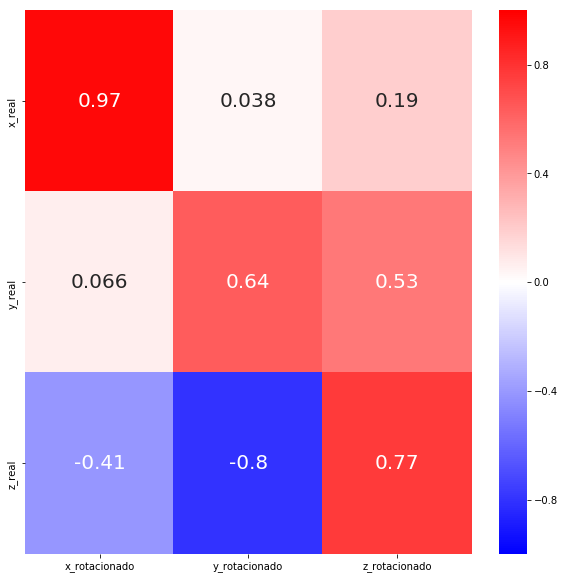

In [68]:
hm = df_merged.loc[end:,["x_acc","y_acc","z_acc",
                         "x_acc_rotated","y_acc_rotated","z_acc_rotated"]]
hm.columns = ["x_real","y_real","z_real","x_rotacionado","y_rotacionado","z_rotacionado"]
hm_corr = hm.corr()

plt.figure(figsize=(10,10))
s = sns.heatmap(hm_corr.loc[["x_real","y_real","z_real"],
               ["x_rotacionado","y_rotacionado","z_rotacionado"]],annot=True,
                annot_kws={"size": 20},vmin=-1,vmax=1,cmap = "bwr",fmt='.2g')

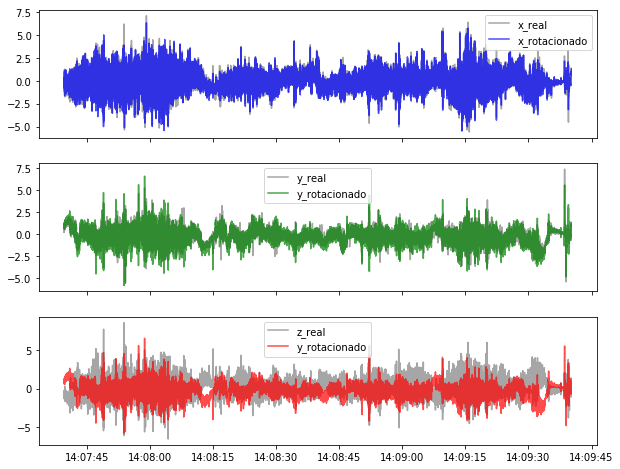

In [69]:
colors = ["b","g","r"]
fig,ax = plt.subplots(3,figsize=(10,8),sharex=True)
for i, eixo in zip(range(3),hm_corr.columns.to_list()[:3]):
  eixo_correlacionado = hm_corr.loc[:,eixo].abs().sort_values(ascending=False).index[1]
  ax[i].plot(hm.index,hm.loc[:,eixo],color="gray",alpha=0.7,label=eixo)
  ax[i].plot(hm.index,hm.loc[:,eixo_correlacionado],color=colors[i],alpha=0.7,label=eixo_correlacionado)
  ax[i].legend()

In [70]:
df_rotated = df_merged.loc[end:,
               ["x_acc_rotated",
                "y_acc_rotated",
                "z_acc_rotated"]].rolling(100,1).mean()

var_sum = df_merged.loc[end:,
               ["x_acc_rotated",
                "y_acc_rotated",
                "z_acc_rotated"]].rolling(100,1).mean().var().sum()
sample_var = df_merged.loc[end:,
               ["x_acc_rotated",
                "y_acc_rotated",
                "z_acc_rotated"]].rolling(100,1).mean().var()
ammount_of_energy = sample_var/var_sum*100
np.round(ammount_of_energy,2)

x_acc_rotated    28.78
y_acc_rotated    63.61
z_acc_rotated     7.61
dtype: float64

Text(0.5, 1.0, 'Quantidade de Energia por Eixo')

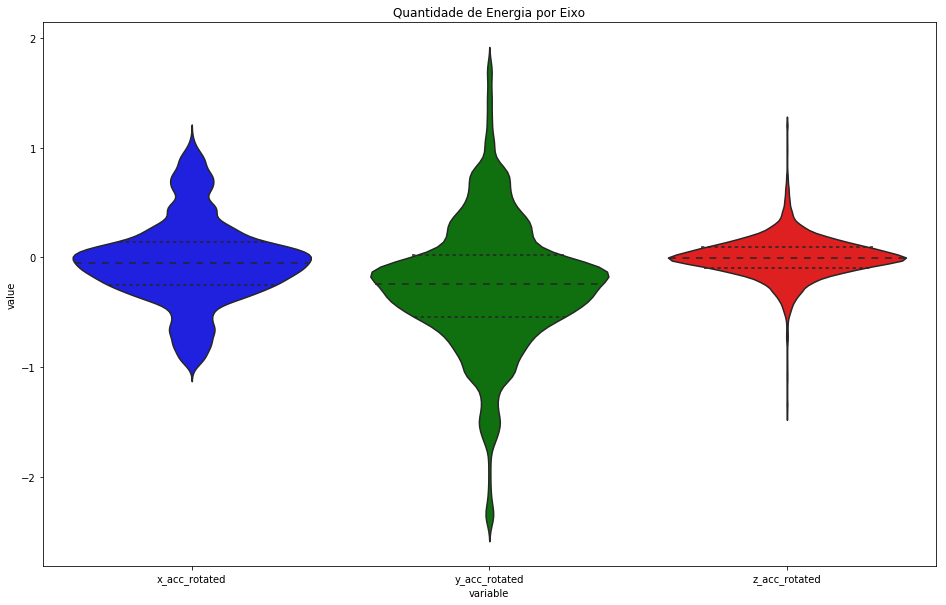

In [71]:
plt.figure(figsize=(16,10))
sns.violinplot(data = df_rotated.melt(),x="variable",y="value",
               scale="count",inner="quartile",
               palette=["b","g","r"])
plt.title("Quantidade de Energia por Eixo")

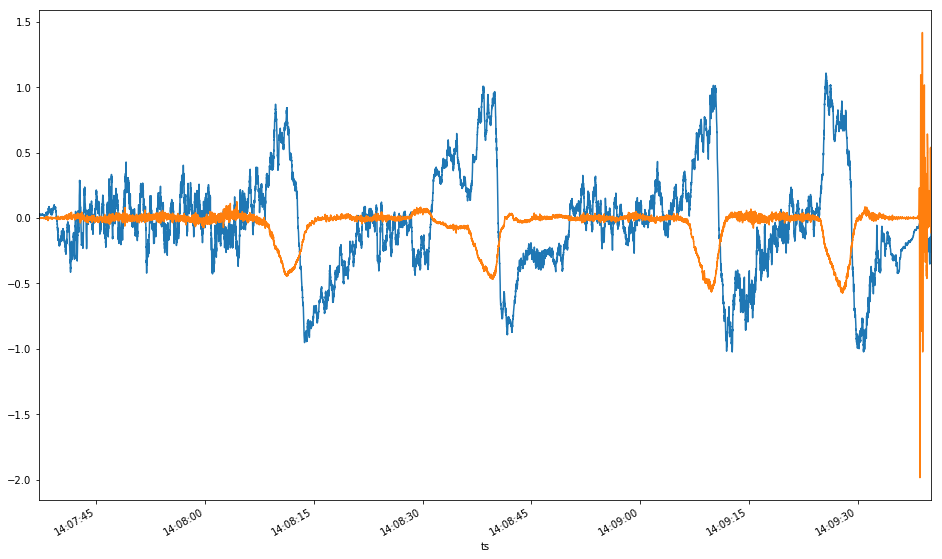

In [72]:
plt.figure(figsize=(16,10))
df_merged.x_acc_rotated.rolling(100,1).mean().plot()
df_merged.z_gyro_rotated.plot()